In [1]:
!pip install matplotlib --upgrade
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import statsmodels.api as sm
import seaborn as sns

In [2]:
#plt.rc('font',family='Times New Roman')

In [5]:
race_table = pd.read_csv('nyra_race_table.csv')
start_table = pd.read_csv('nyra_start_table.csv', header=None)
# tracking_table = pd.read_csv('/kaggle/input/big-data-derby-2022/nyra_tracking_table.csv')
start_table.columns=['track_id', 'race_date', 'race_number', 'program_number', 'weight_carried', 'jockey', 'odds', 'position_at_finish']

In [6]:
race_type_dict =   {  'STK': 'Stakes', 
                      'WCL': 'Waiver Claiming', 
                      'WMC': 'Waiver Maiden Claiming', 
                      'SST': 'Starter Stakes', 
                      'SHP': 'Starter Handicap',
                      'CLM': 'Claiming', 
                      'STR': 'Starter Allowance', 
                      'AOC': 'Allowance Optionl Claimer', 
                      'SOC': 'Starter Optional Claimer', 
                      'MCL': 'Maiden Claiming', 
                      'ALW': 'Allowance', 
                      'MSW': 'Maiden Special Weight'
                      }

track_id_dict = dict(AQU = 'Aqueduct', BEL = 'Belmont', SAR = 'Saratoga')
course_type_dict = dict(M = 'Hurdle', D = 'Dirt', O = 'Outer turf', I = 'Inner turf', T = 'turf')
track_condition_dict =  dict(YL = 'Yielding', FM ='Firm', SY = 'Sloppy', GD = 'Good', FT = 'Fast', MY = 'Muddy', SF = 'Soft')

race_table['race_type'] = race_table['race_type'].map(race_type_dict)
race_table['track_id'] = race_table['track_id'].map(track_id_dict)
race_table['course_type'] = race_table['course_type'].map(course_type_dict)

race_table['track_condition']=race_table['track_condition'].apply(lambda x:x.replace(" ", ''))
race_table['track_condition'] = race_table['track_condition'].map(track_condition_dict)


start_table['track_id'] = start_table['track_id'].map(track_id_dict)

print(start_table.shape, race_table.shape)
start_table = start_table.merge(race_table, on=['track_id','race_date', 'race_number'], how='inner')
print(start_table.shape, race_table.shape)

(14915, 8) (2000, 10)
(14915, 15) (2000, 10)


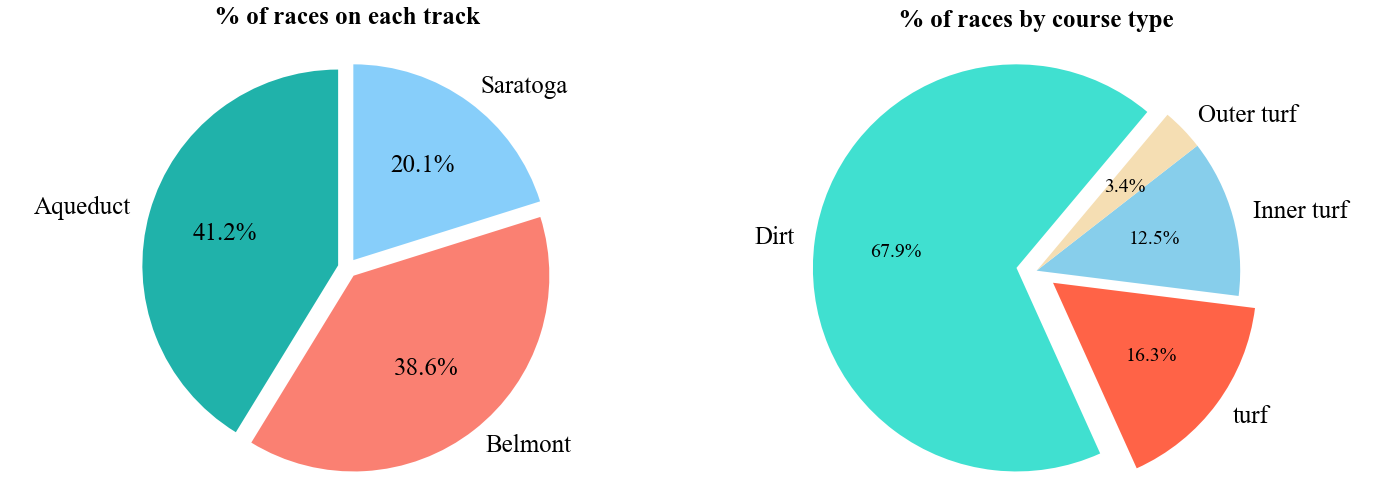

In [7]:
cs = race_table['track_id'].value_counts().sort_values(ascending=False)
cs1 = race_table['course_type'].value_counts().sort_values(ascending=False)[:-1]

fig=plt.figure(figsize=(20,7),facecolor='white')
gs=fig.add_gridspec(1,2)

ax0=fig.add_subplot(gs[0,0])
ax1=fig.add_subplot(gs[0,1])

#colormap1=['firebrick','LightCoral','Salmon','DarkSalmon','mistyrose']
#colormap2=['mistyrose','LightCoral','firebrick','Salmon','DarkSalmon','LightSalmon']

colormap1 = ['lightseagreen', 'salmon', 'lightskyblue', 'mediumseagreen', 'sandybrown', 'lightslategray', 'wheat', 'crimson']
colormap2 = ['turquoise', 'tomato', 'skyblue', 'wheat', 'peru', 'slategray', 'tan',  'firebrick']

ax0.text(-0,1.25,"% of races on each track",fontsize=25,fontweight='bold',ha='center', fontfamily='Times New Roman')
ax1.text(-0,1.2,"% of races by course type",fontsize=25,fontweight='bold',ha='center', fontfamily='Times New Roman')

patches1,l1_text,p1_text=ax0.pie(cs.values, explode=[0.05,0.05,0.05],labels=cs.index.values, autopct='%1.1f%%',
        shadow=False, startangle=90,colors=colormap1, )

patches2,l2_text,p2_text=ax1.pie(cs1.values, explode=[0.1,0.1,0, 0],labels=cs1.index.values, autopct='%1.1f%%',
        shadow=False, startangle=50,colors=colormap2)

for t in p1_text:
    t.set_size(25)
    t.set_family('Times New Roman')

for t in l1_text:
    t.set_size(25)
    t.set_family('Times New Roman')
    
for t in p2_text:
    t.set_size(20)
    t.set_family('Times New Roman')

for t in l2_text:
    t.set_size(25)
    t.set_family('Times New Roman')


ax0.axis('equal')
ax1.axis('equal')
plt.tight_layout()
#plt.savefig('pic1.png', dpi=500, bbox_inches='tight')
plt.show()


In [8]:
def post_time_(x):
    v = '12:00'
    if (x is None)|(x is np.nan):
        return v
    else:
        x = str(x)
        x1_ = int(x[:-2])
        x2_ = int(x[-2:])
        if x1_<10:
            x1_ = x1_ + 12
        if x2_<22:
            v = f'{x1_}:00'
        elif x2_< 48: 
            v = f'{x1_}:30'
        else: 
            v = f'{x1_+1}:00'
    return v

In [9]:
race_date = pd.to_datetime(race_table['race_date'])



rd = pd.DataFrame(data={'weekday': race_date.dt.weekday, 
                        'month_name':race_date.dt.strftime("%b"),
                        'month':race_date.dt.month,
                        'week': race_date.dt.isocalendar().week,
                        'day_name': race_date.dt.day_name(),
                        'race_number': race_table['race_number'], 
                        'post_time': race_table['post_time'].apply(post_time_),
                        'track': race_table['track_id'] ,
                       }
                 )

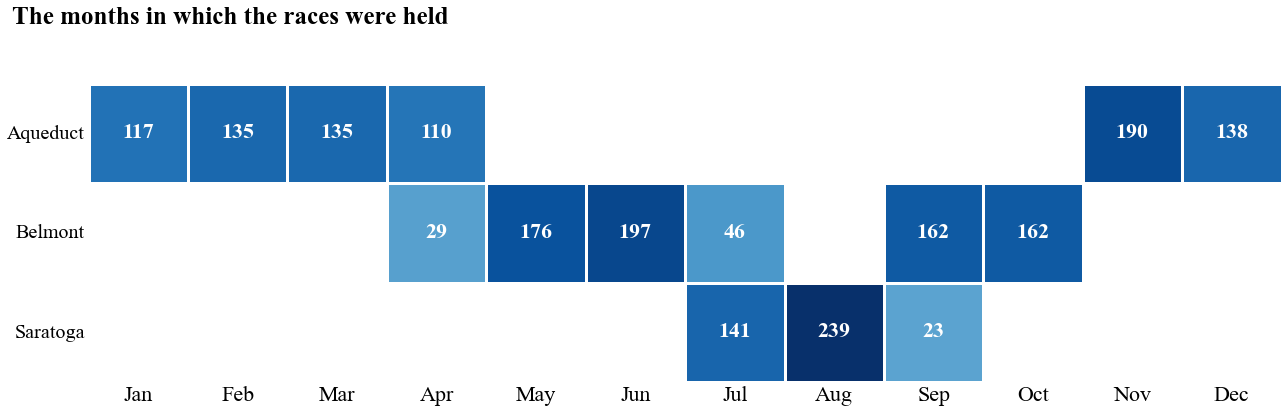

In [10]:
#Which months did races take place on each track?
cs = pd.pivot_table(rd, index=['track'], columns=['month'], values='day_name', aggfunc=np.size)

mnth_map = rd[['month', 'month_name']].drop_duplicates().sort_values(by='month').set_index(keys='month').to_dict()['month_name']

cs.columns = [mnth_map[a] for a in cs.columns]
#cs.index = [day_map[a] for a in cs.index]
cs.index.name=''

fig, ax = plt.subplots(1, 1, figsize=(18, 7))
sns.heatmap(cs, xticklabels=cs.columns, yticklabels=cs.index, cmap='Blues', square=True, linewidth=2.5,cbar=False,
            center=0, annot=True,fmt='.0f',ax=ax,annot_kws={"fontsize":22,'weight':'bold'})#YlGnBu#RdYlGn

ax.spines['top'].set_visible(False)
fig.text(.012, .915, 'The months in which the races were held', fontweight='bold', fontsize=25,ha='left')   

ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=22)

ax.set_ylabel('')    
ax.set_xlabel('')
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.tight_layout()
#plt.savefig('pic2.png', dpi=500, bbox_inches='tight')
plt.show()

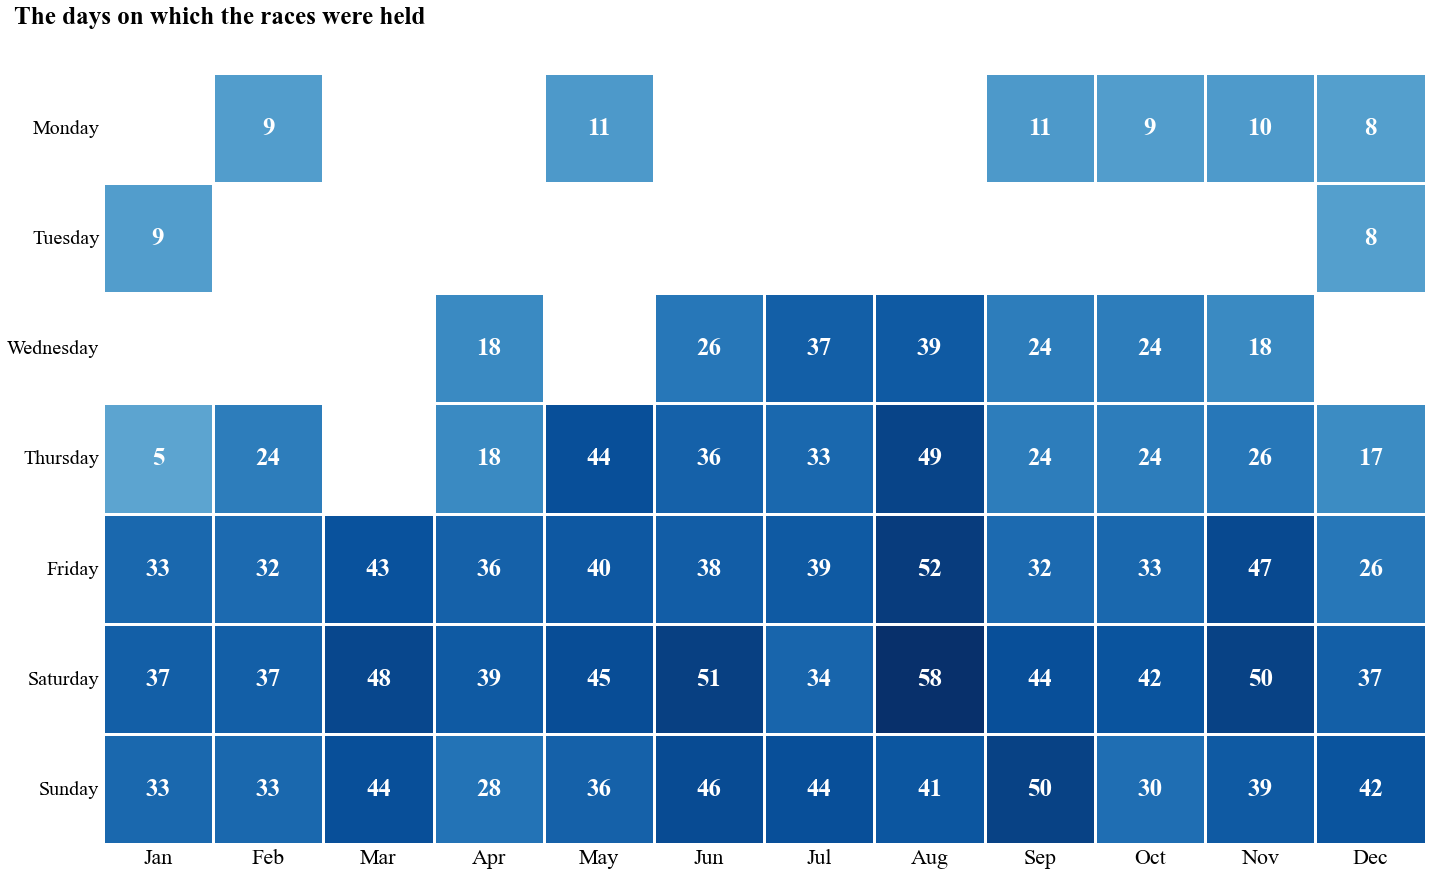

In [11]:
#When day in the week did races take place?
cs = pd.pivot_table(rd, index=['weekday'], columns=['month'], values='day_name', aggfunc=np.size)

mnth_map = rd[['month', 'month_name']].drop_duplicates().sort_values(by='month').set_index(keys='month').to_dict()['month_name']
day_map = rd[['weekday', 'day_name']].drop_duplicates().sort_values(by='weekday').set_index(keys='weekday').to_dict()['day_name']

cs.columns = [mnth_map[a] for a in cs.columns]
cs.index = [day_map[a] for a in cs.index]

fig, ax = plt.subplots(1, 1, figsize=(20, 13))
sns.heatmap(cs, xticklabels=cs.columns, yticklabels=cs.index, cmap='Blues', square=True, linewidth=2.5,cbar=False,
            center=0, annot=True,  fmt='.0f', 
            ax=ax,annot_kws={"fontsize":25,'weight':'bold'})#YlGnBu#RdYlGn

ax.spines['top'].set_visible(False)

ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=22)

fig.text(.012, .965, 'The days on which the races were held', fontweight='bold', fontsize=25,ha='left') 

ax.set_ylabel('')    
ax.set_xlabel('')
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.tight_layout()
#plt.savefig('pic3.png', dpi=500, bbox_inches='tight')
plt.show()

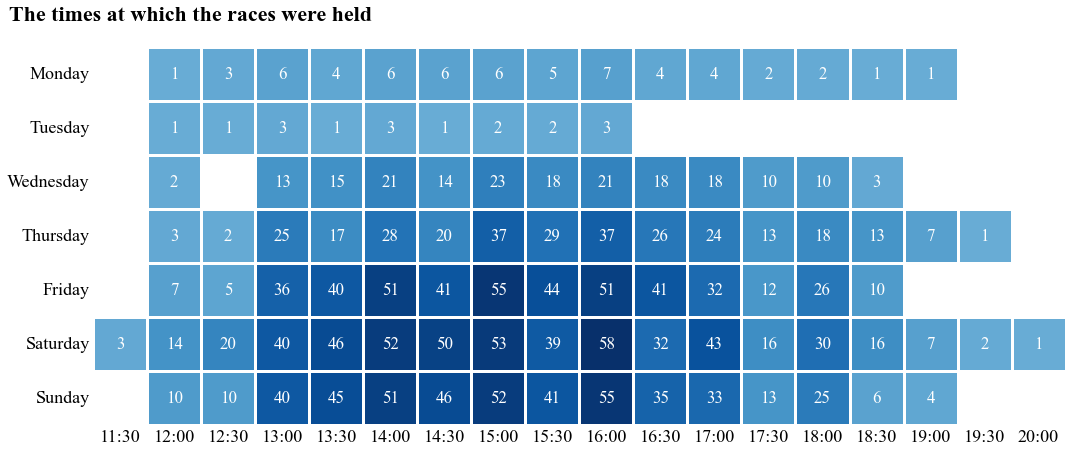

In [12]:
cs = pd.pivot_table(rd, index=['weekday'], columns=['post_time'], values='day_name', aggfunc=np.size)
day_map = rd[['weekday', 'day_name']].drop_duplicates().sort_values(by='weekday').set_index(keys='weekday').to_dict()['day_name']
cs.columns.name=''
cs.index = [day_map[a] for a in cs.index]


fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.heatmap(cs, xticklabels=cs.columns, yticklabels=cs.index, cmap='Blues', square=True, linewidth=2.5,cbar=False,
            center=0, annot=True,  fmt='.0f', 
            ax=ax,annot_kws={"fontsize":17})#YlGnBu#RdYlGn

ax.spines['top'].set_visible(False)
fig.text(.012, .8, 'The times at which the races were held', fontweight='bold', fontsize=22,ha='left')   

ax.set_yticklabels(ax.get_yticklabels(),rotation = 0, fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 0, fontsize=18)

ax.set_ylabel('')    
ax.set_xlabel('')
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.tight_layout()
#plt.savefig('pic4.png', dpi=500, bbox_inches='tight')
plt.show()


In [13]:
datas = [
    race_table[['race_date', 'race_number']].groupby('race_date').count()['race_number'].value_counts().sort_index(),  
    start_table[['race_date', 'race_number', 'program_number']].groupby(['race_date', 'race_number',]).count()['program_number'].value_counts().sort_index(), 
]
captions = [
    'Number of races per day',
    'Number of horses per race'
]

/var/folders/rs/_y7gb8yj2k7_qnpt5zsnl19c0000gn/T/ipykernel_89865/1155228404.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
/var/folders/rs/_y7gb8yj2k7_qnpt5zsnl19c0000gn/T/ipykernel_89865/1155228404.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(axs[i].get_yticklabels(), rotation = 0, fontfamily='Times New Roman', fontsize=18)
/var/folders/rs/_y7gb8yj2k7_qnpt5zsnl19c0000gn/T/ipykernel_89865/1155228404.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=0, fontfamily='Times New Roman', fontsize=18)
/var/folders/rs/_y7gb8yj2k7_qnpt5zsnl19c0000gn/T/ipykernel_89865/1155228404

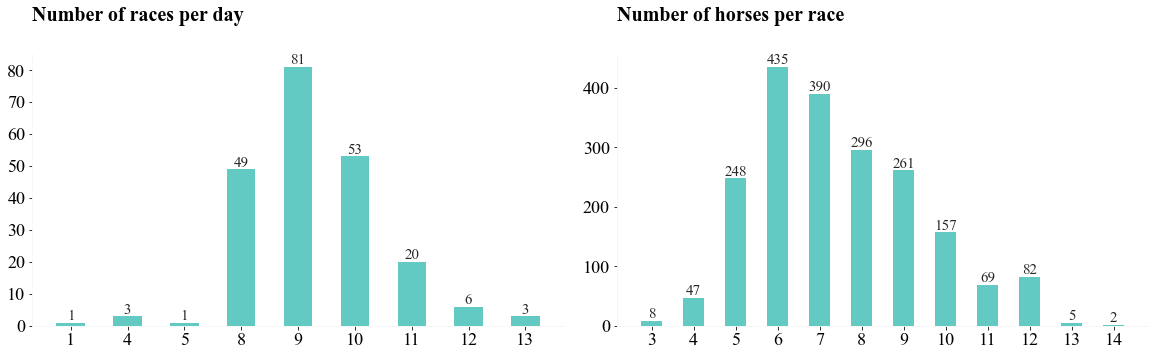

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
plt.style.use('seaborn-whitegrid')

    
for i, data in enumerate(datas):
    if data.index.dtype in ['int64', 'int32', 'float64', 'float32']:
        data.index = data.index.astype(str)

    axs[i].bar(data.index.values, data.values, color="lightseagreen", width=.5, alpha=0.7)
    axs[i].bar_label(axs[i].containers[0], labels=data.values, label_type='edge', fontfamily='Times New Roman',fontsize=15)
    axs[i].grid(visible=False)
    axs[i].spines[['top', 'right']].set_visible(False)
    axs[i].spines[['bottom', 'left']].set_edgecolor('whitesmoke')
    
    #axs[i].set_ylabel(data.name)
    axs[i].set_title(captions[i], fontsize=20, fontfamily='Times New Roman', fontweight="bold", loc='left',y=1.1)
    axs[i].set_yticklabels(axs[i].get_yticklabels(), rotation = 0, fontfamily='Times New Roman', fontsize=18)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=0, fontfamily='Times New Roman', fontsize=18)
    


#     plt.suptitle('')
ax.spines['top'].set_visible(False)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None) # useful for adjusting space between subplots
#plt.savefig('pic5.png', dpi=500, bbox_inches='tight')
plt.show()

In [16]:
def multi_bar(datas, captions, figsize=(20, 5), sharey=False):
    ncols = len(datas)
    fig, axs = plt.subplots(1, ncols, figsize=figsize, sharey=sharey)
    plt.style.use('seaborn-whitegrid')
    
    for i, data in enumerate(datas):
        if data.index.dtype in ['int64', 'int32', 'float64', 'float32']:
            data.index = data.index.astype(str)
            
        axs[i].bar(data.index.values, data.values, color="lightseagreen", width=.5, alpha=0.7)
        axs[i].bar_label(axs[i].containers[0], labels=data.values, label_type='edge', fontsize=15, fontfamily='Times New Roman')
        axs[i].grid(visible=False)
        axs[i].spines[['top', 'right']].set_visible(False)
        axs[i].spines[['bottom', 'left']].set_edgecolor('whitesmoke')

        #axs[i].set_ylabel(data.name)
        axs[i].set_title(captions[i], fontsize=20, fontfamily='Times New Roman', loc='left',y=1.1,fontweight="bold")
        axs[i].set_yticklabels(axs[i].get_yticklabels(), rotation = 0, fontfamily='Times New Roman', fontsize=15)
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=0, fontfamily='Times New Roman', fontsize=16)

    
#     plt.suptitle('')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)
    #plt.savefig('pic6.png', dpi=500, bbox_inches='tight')
    plt.show()    

/var/folders/rs/_y7gb8yj2k7_qnpt5zsnl19c0000gn/T/ipykernel_89865/3200027420.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
/var/folders/rs/_y7gb8yj2k7_qnpt5zsnl19c0000gn/T/ipykernel_89865/3200027420.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(axs[i].get_yticklabels(), rotation = 0, fontfamily='Times New Roman', fontsize=15)
/var/folders/rs/_y7gb8yj2k7_qnpt5zsnl19c0000gn/T/ipykernel_89865/3200027420.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=0, fontfamily='Times New Roman', fontsize=16)
/var/folders/rs/_y7gb8yj2k7_qnpt5zsnl19c0000gn/T/ipykernel_89865/3200027420

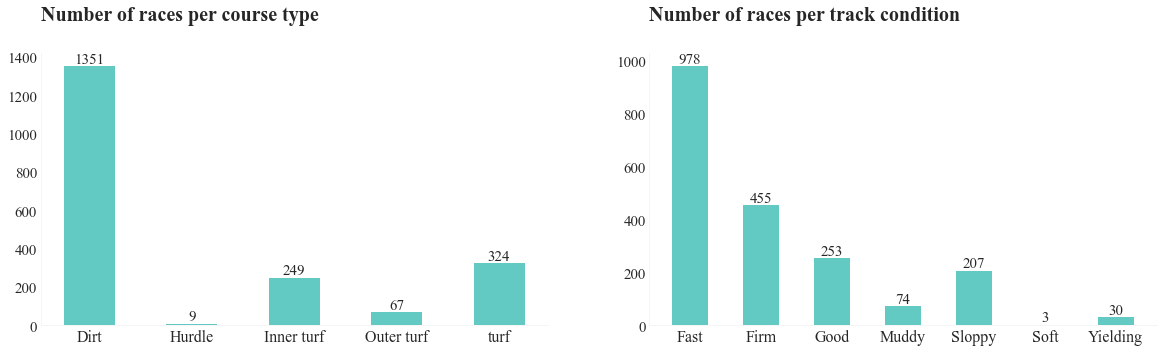

In [17]:
datas = [
    race_table['course_type'].value_counts().sort_index(),  
    race_table['track_condition'].value_counts().sort_index(), 
]
captions = [
    'Number of races per course type',
    'Number of races per track condition'
]

multi_bar(datas, captions=captions, figsize=(20, 5))

/var/folders/rs/_y7gb8yj2k7_qnpt5zsnl19c0000gn/T/ipykernel_89865/2302381848.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontfamily='Times New Roman', fontsize=18)


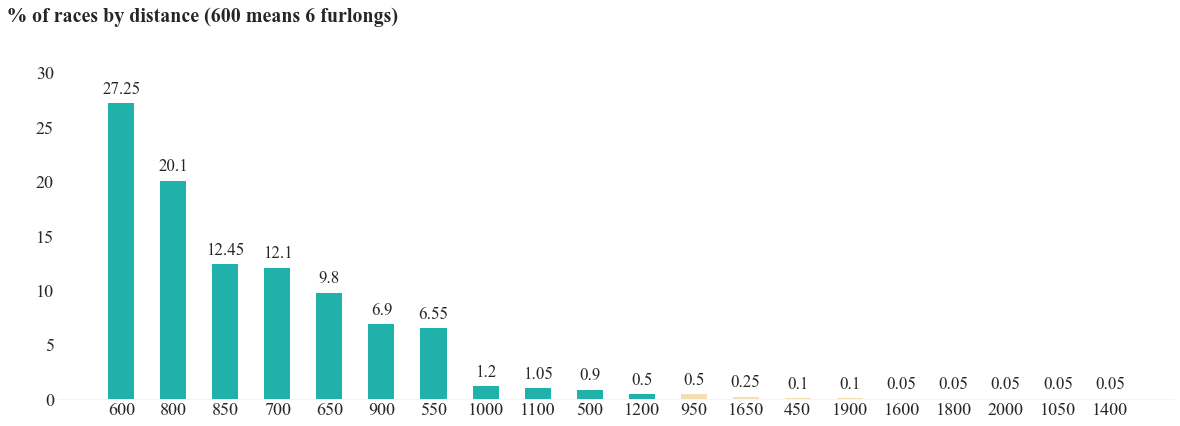

In [18]:
data = race_table['distance_id'].value_counts().sort_values(ascending=False)/20
data.index = data.index.astype(str)
#data = data[data>0.1]
# Plot

color_map = ['lightseagreen' ]*11 + ['wheat']*(data.size - 11)


fig, ax = plt.subplots(1,1, figsize=(20, 6))
ax.bar(data.index, data, width=0.5, 
       #edgecolor='darkgray',
       linewidth=0.6,color=color_map)
#annotations
for i in data.index:
    ax.annotate(f"{data[i]}", 
                   xy=(i, data[i] + 1.250), 
                   va = 'center', ha='center', fontsize=17, fontfamily='Times New Roman')

# Remove border from plot

for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
    

fig.text(0.09, 1, '% of races by distance (600 means 6 furlongs)', fontsize=20, fontfamily='Times New Roman', fontweight='bold')
#fig.text(0.09, 0.95, 'The top 5 distances are highlighted, only display distances with more than 1% of races.', fontsize=13, fontweight='light', fontfamily='monospace')
ax.grid(axis='y', linestyle='-', alpha=0.4)   
ax.grid(axis='x', linestyle='-', alpha=0.4) 
grid_y_ticks = np.arange(0, 35, 5) # y ticks, min, max, then step
ax.set_yticks(grid_y_ticks,fontsize=22,fontfamily='Times New Roman')
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontfamily='Times New Roman', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontfamily='Times New Roman', fontsize=18)
ax.set_axisbelow(True)

#plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
#plt.axvline(x = 0, color = 'black', linewidth = 0.8, alpha = .7)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.grid(visible=False)
ax.spines[['top', 'right']].set_visible(False)
ax.spines[['bottom', 'left']].set_edgecolor('whitesmoke')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)
#plt.savefig('pic7.png', dpi=500, bbox_inches='tight')
plt.show()

/var/folders/rs/_y7gb8yj2k7_qnpt5zsnl19c0000gn/T/ipykernel_89865/2740573178.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontfamily='Times New Roman', fontsize=20)


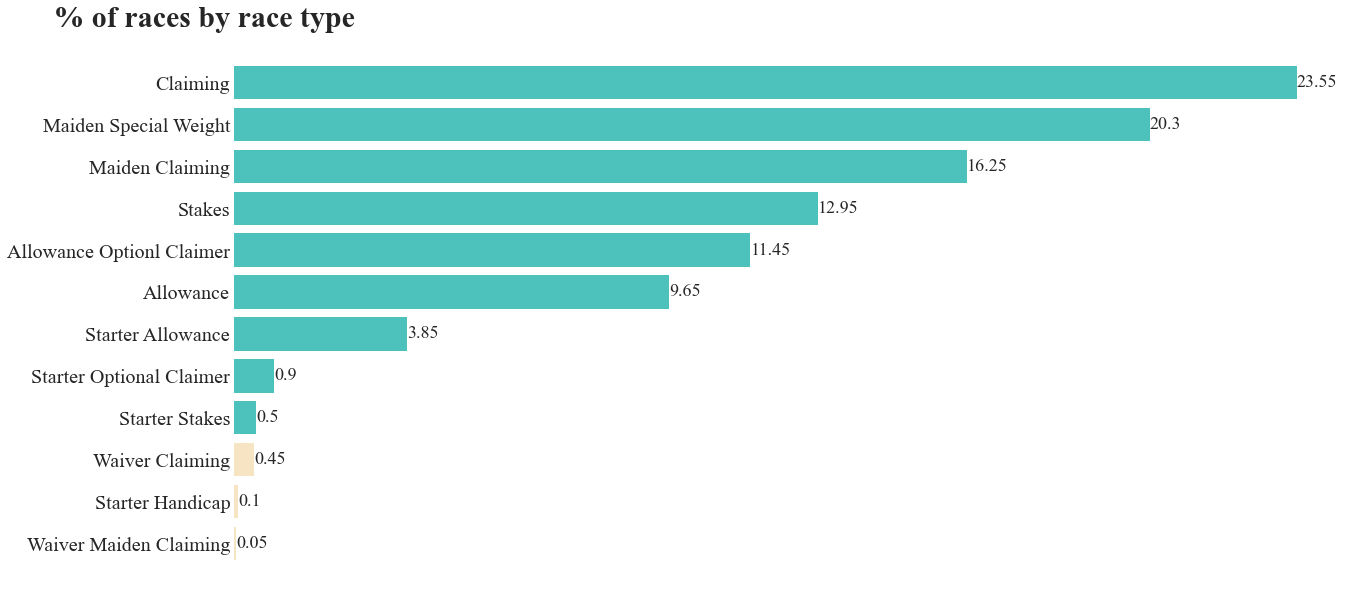

In [19]:
data = race_table['race_type'].value_counts().sort_values()/20
data.index = data.index.astype(str)
#data = data[data>0.1]
# Plot

color_map =  ['wheat']*3 + ['lightseagreen' ]*9


fig, ax = plt.subplots(1,1, figsize=(20, 10))
ax.barh(y = data.index.values, width = data.values, height=0.8, color=color_map, alpha=0.8)
ax.bar_label(ax.containers[0], labels=data.values, label_type='edge', fontsize=18,fontfamily='Times New Roman')

    

fig.text(0, 0.9, '% of races by race type', fontsize=30, fontweight='bold', fontfamily='Times New Roman')
#fig.text(0.0, 0.915, 'The top 3 race types are highlighted', fontsize=15, fontweight='light', fontfamily='monospace')
ax.grid(axis='y', linestyle='-', alpha=0.4)   
ax.set_xticks([])


ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(visible=False)
ax.spines[['top', 'right','bottom', 'left']].set_visible(False)
#ax.spines[['bottom', 'left']].set_edgecolor('whitesmoke')

#ax.set_yticks(grid_y_ticks,fontsize=22,fontfamily='Times New Roman')
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontfamily='Times New Roman', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontfamily='Times New Roman', fontsize=20)

for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
#plt.savefig('pic8.png', dpi=500, bbox_inches='tight')
plt.show()